# NYC 311 Service Requests

*Problem:*
- Currently, the time it takes to fully resolve a 311 service request varies significantly, impacting citizen satisfaction and operational efficiency.
- Long resolution times can be caused by a variety of factors, including resource constraints, complex workflows, inter-agency dependencies, and unforeseen delays.
- Without accurate predictions of resolution times, it's difficult to identify bottlenecks, optimize processes, and allocate resources effectively to expedite the
closure of requests.
- Extended resolution times lead to increased call volumes from citizens checking on the status of their requests, further straining resources and impacting service quality

*Solution:*  
Introducing the XGBoost Resolution Time Forecasting Model
XGBoost model provides highly accurate (96%) forecasts of 311 service request resolution times, analyzing data from 2022 to 2025 to predict how long it will take 
to close a request.
The model considers a wide range of factors, including request type, location, time of day, day of week, weather, historical resolution data.
    
This model anticipates how long it will take to resolve a request from start to finish, enabling proactive intervention and resource optimization to minimize delays.

Here's where the benefits get tailored to resolution time:
1) **Proactive Bottleneck Identification and Mitigation:**
  "The model allows us to proactively identify potential bottlenecks in the resolution process *before* they cause significant delay.
Example: If the model predicts that a particular type of request will experience a longer-than-average resolution time due to limited personel availability, the agency can proactively allocate additional personnel or streamline the approval process to expedite the closure of these requests.
2) **Optimized Workflow Management:**
  "The forecasts enable optimized workflow management, ensuring that each step in the resolution process is completed as efficiently as possible"**Exampl "The model can identify situations where a request is stalled due to a delay in obtaining necessary approvals from other agencies. In these cases, the agen
y can proactively escalate the request or work with the other agency to expedite the approval proces
4) **Proactive Citizen Communication:**
  "The model can be used to provide citizens with more accurate estimates of when their requests will be resolved, managing expectations and reducing the need for follow-up calls"**Exampl* "When a citizen submits a request, the system can provide an estimated resolution time based on the model's forecast, along with regular updates on the progress of the reques.".s




This notebook runs a model to predict the repsonse time from a selected set of features of the 311 Service Requests dataset.

1) Agency: City department or organization responsible for handling a specific type of request.
NYC 311 routes service requests to the appropriate agency based on the complaint type.
Common agencies include:
NYPD → New York Police Department (for noise complaints, illegal parking, etc.)
DOT → Department of Transportation (for street conditions, traffic signals, etc.)
DOB → Department of Buildings (for building code violations)
DSNY → Department of Sanitation (for trash removal, graffiti cleanup)
DEP → Department of Environmental Protection (for water leaks, noise from construction)

2) NYC has 5 boroughs, each acting like a separate county:
Manhattan (New York County)
Brooklyn (Kings County)
Queens (Queens County)
The Bronx (Bronx County)
Staten Island (Richmond County)
When a service request is submitted, the borough field tells us where in NYC the issue was reported.

### Loading dependencies

In [7]:
import datetime as dt
import logging
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb #Xgboost version 3.0

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.WARNING)

logging.getLogger('matplotlib').setLevel(logging.WARNING)

from data_preprocessor import preprocessDataset
from train import modelData, modelDataWithGridSearch

C:\Users\sim-graziella\Documents\Uptimal\NYC-311-service-requests\train.py:218: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('SVR', svr_model)


# Importing the Data

Data was downloaded from https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data as csv file

In [9]:
csv_path = '../311ServiceRequests.csv'

data = pd.read_csv(csv_path,usecols=['Created Date', 'Closed Date','Agency','Borough','Complaint Type','City','Street Name',
                 'Open Data Channel Type','Latitude','Longitude'])

In [27]:
data.tail()

,Created Date,Closed Date,Agency,Complaint Type,Street Name,City,Borough,Open Data Channel Type,Latitude,Longitude
39380344,10/21/2024 12:57:04 PM,10/21/2024 12:57:04 PM,DOHMH,Rodent,59 STREET,WOODSIDE,QUEENS,PHONE,40.745128,-73.905674
39380345,10/21/2024 11:26:14 AM,10/21/2024 11:26:14 AM,DOHMH,Rodent,EMMONS AVENUE,BROOKLYN,BROOKLYN,MOBILE,40.583919,-73.937886
39380346,10/21/2024 09:27:01 PM,10/21/2024 10:06:24 PM,NYPD,Abandoned Vehicle,7 AVENUE,NaN,MANHATTAN,ONLINE,40.748469,-73.992461
39380347,10/21/2024 01:50:11 PM,10/21/2024 02:34:30 PM,NYPD,Abandoned Vehicle,HARRISON AVENUE,BROOKLYN,BROOKLYN,MOBILE,40.706199,-73.953880
39380348,10/22/2024 01:21:33 AM,10/22/2024 02:00:02 AM,NYPD,Drug Activity,PARK AVENUE,FRESH MEADOWS,QUEENS,ONLINE,40.729932,-73.809053


# Preprocessing the data:
includes:
- Taking a sample of the data from 2022 to 2025
- Cleaning data from outliers (IQR - interquartile range, which is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of the response times)
- Feature engineering:  
    o Extract sin/cos transformations for latitude and longitude:
      To handle their circular nature properly and preserve spatial relationships in machine learning model.
      (0° to 360° or -180° to 180°) are physically close but numerically far apart. ML models might think they are distant.  
    o Derive time-of-day and day-of-week features  
    o Drop rows with missing values
- Calculate response time and apply log transformation to achieve normality of the skewed data and reduce the outlier impact and help gradient-based models to learn better

In [22]:
df = preprocessDataset(data)
# length of data is 7175855

C:\Users\sim-graziella\Documents\Uptimal\NYC-311-service-requests\data_preprocessor.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanDf['logResponseTime'] = np.log1p(cleanDf['response_time'])


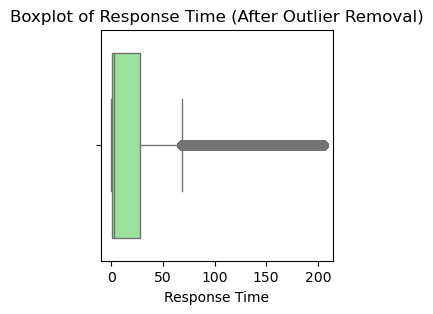

In [23]:
# plt.figure(figsize=(5, 5))
# plt.hist(df['response_time'], bins=30, color='skyblue', edgecolor='black')
# plt.title('Histogram of Response Time (Before Outlier Removal)')
# plt.xlabel('Response Time')
# plt.ylabel('Frequency')
# plt.show()

import seaborn as sns
plt.figure(figsize=(3, 3))
sns.boxplot(x=df['response_time'], color='lightgreen')
plt.title('Boxplot of Response Time (After Outlier Removal)')
plt.xlabel('Response Time')
plt.show()

#The target is highly skewed to the right: a few larger response times remain > 200 hours (8.3 days)

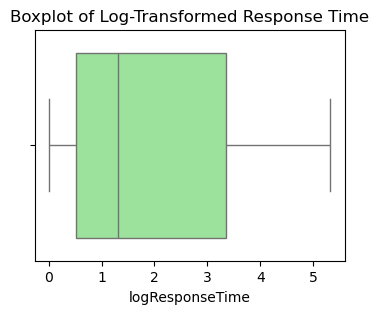

In [24]:
# XGBoost does not assume normality or linearity, so skewness is less of a concern compared to linear models.
# But log-transforming the target variable can improve model performance.

# Plot the transformed data
plt.figure(figsize=(4,3))
sns.boxplot(x=df['logResponseTime'], color='lightgreen')
plt.title("Boxplot of Log-Transformed Response Time")
plt.show()

# Outliers are less extreme in log scale

C:\Users\sim-graziella\AppData\Local\Temp\ipykernel_7640\55554862.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

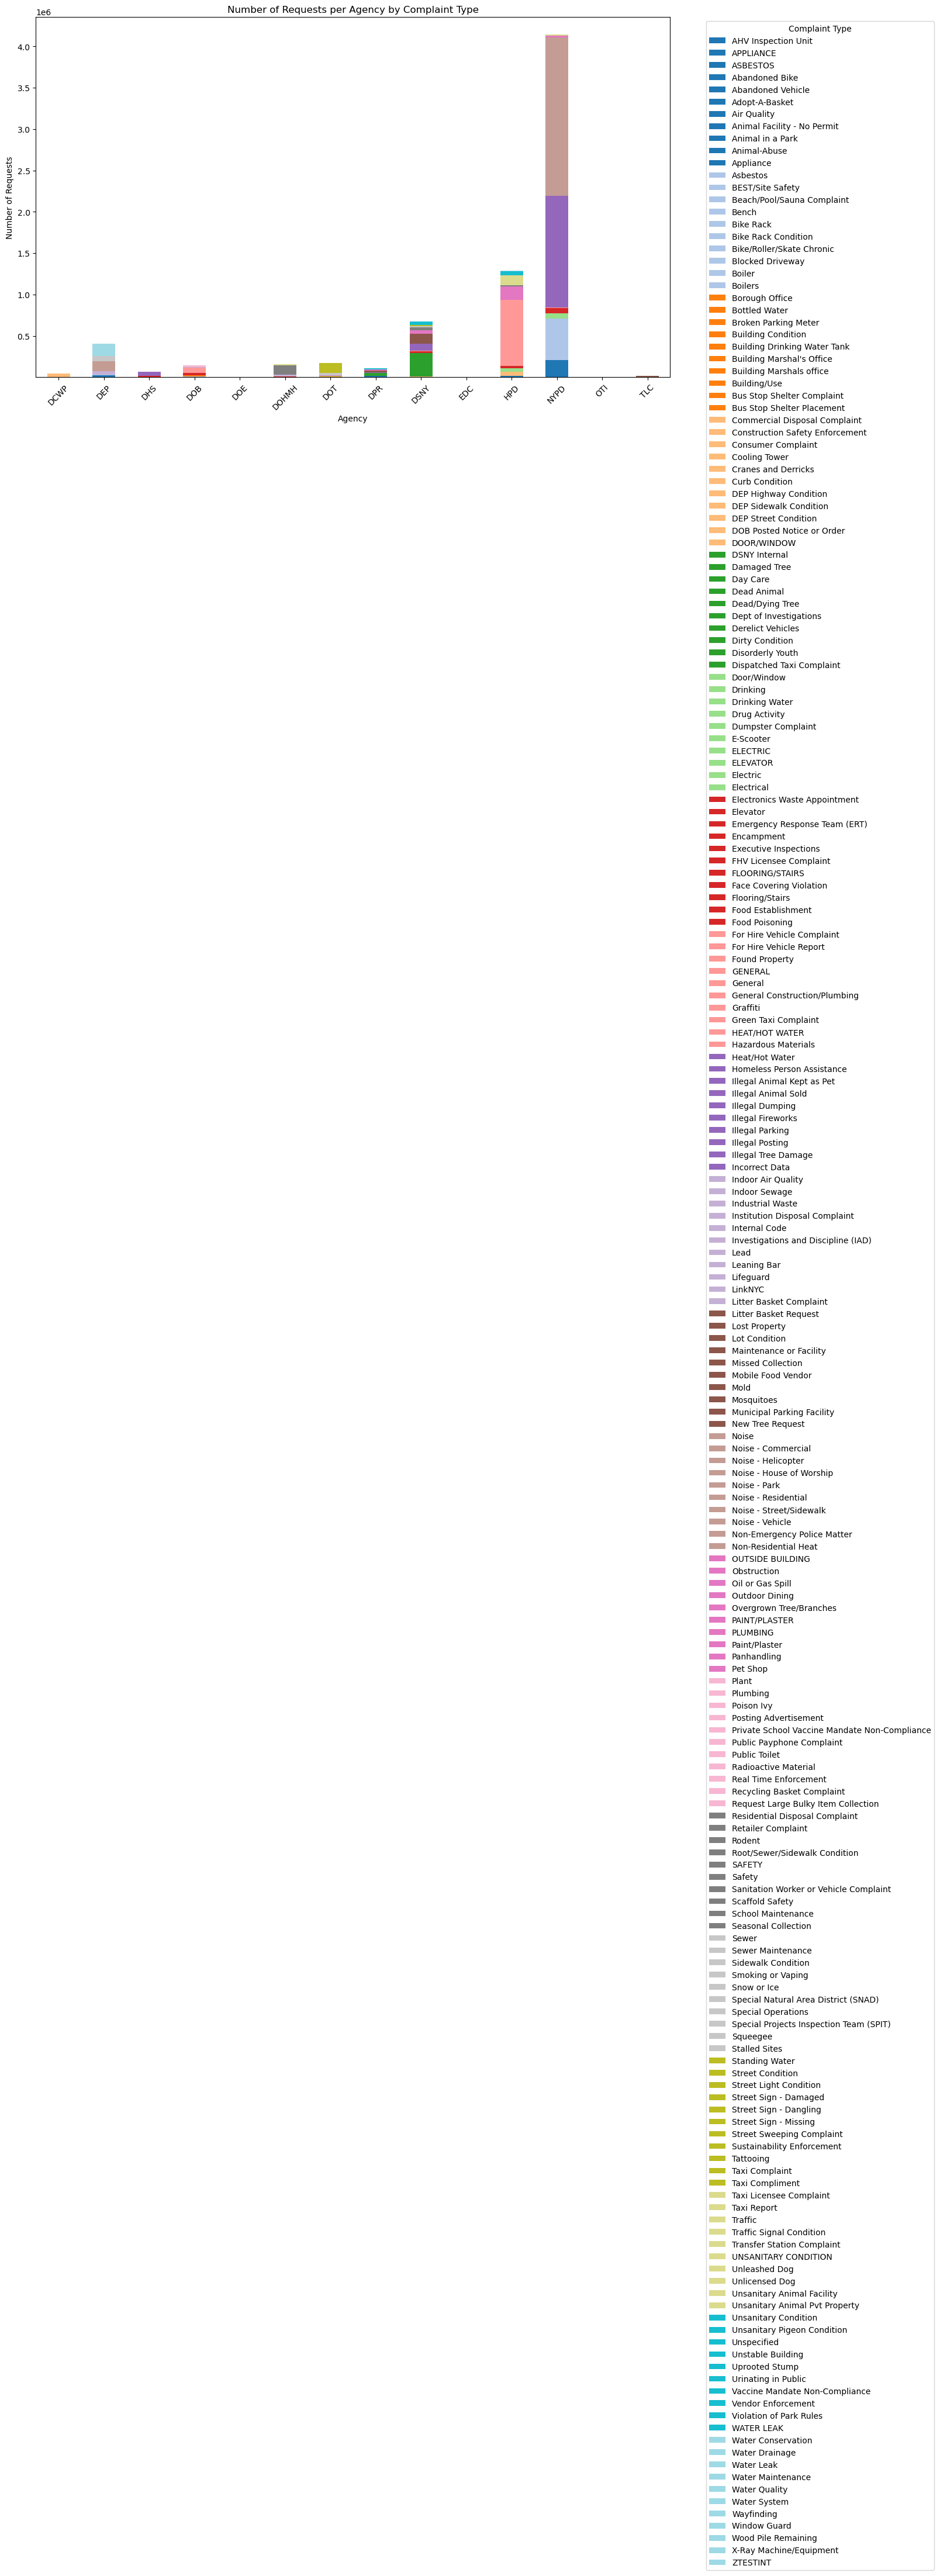

In [36]:
request_counts = df.groupby(['Agency', 'Complaint Type']).size().unstack(fill_value=0)

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
request_counts.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.xlabel('Agency')
plt.ylabel('Number of Requests')
plt.title('Number of Requests per Agency by Complaint Type')
plt.xticks(rotation=45)
plt.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\sim-graziella\AppData\Local\Temp\ipykernel_7640\1749369801.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

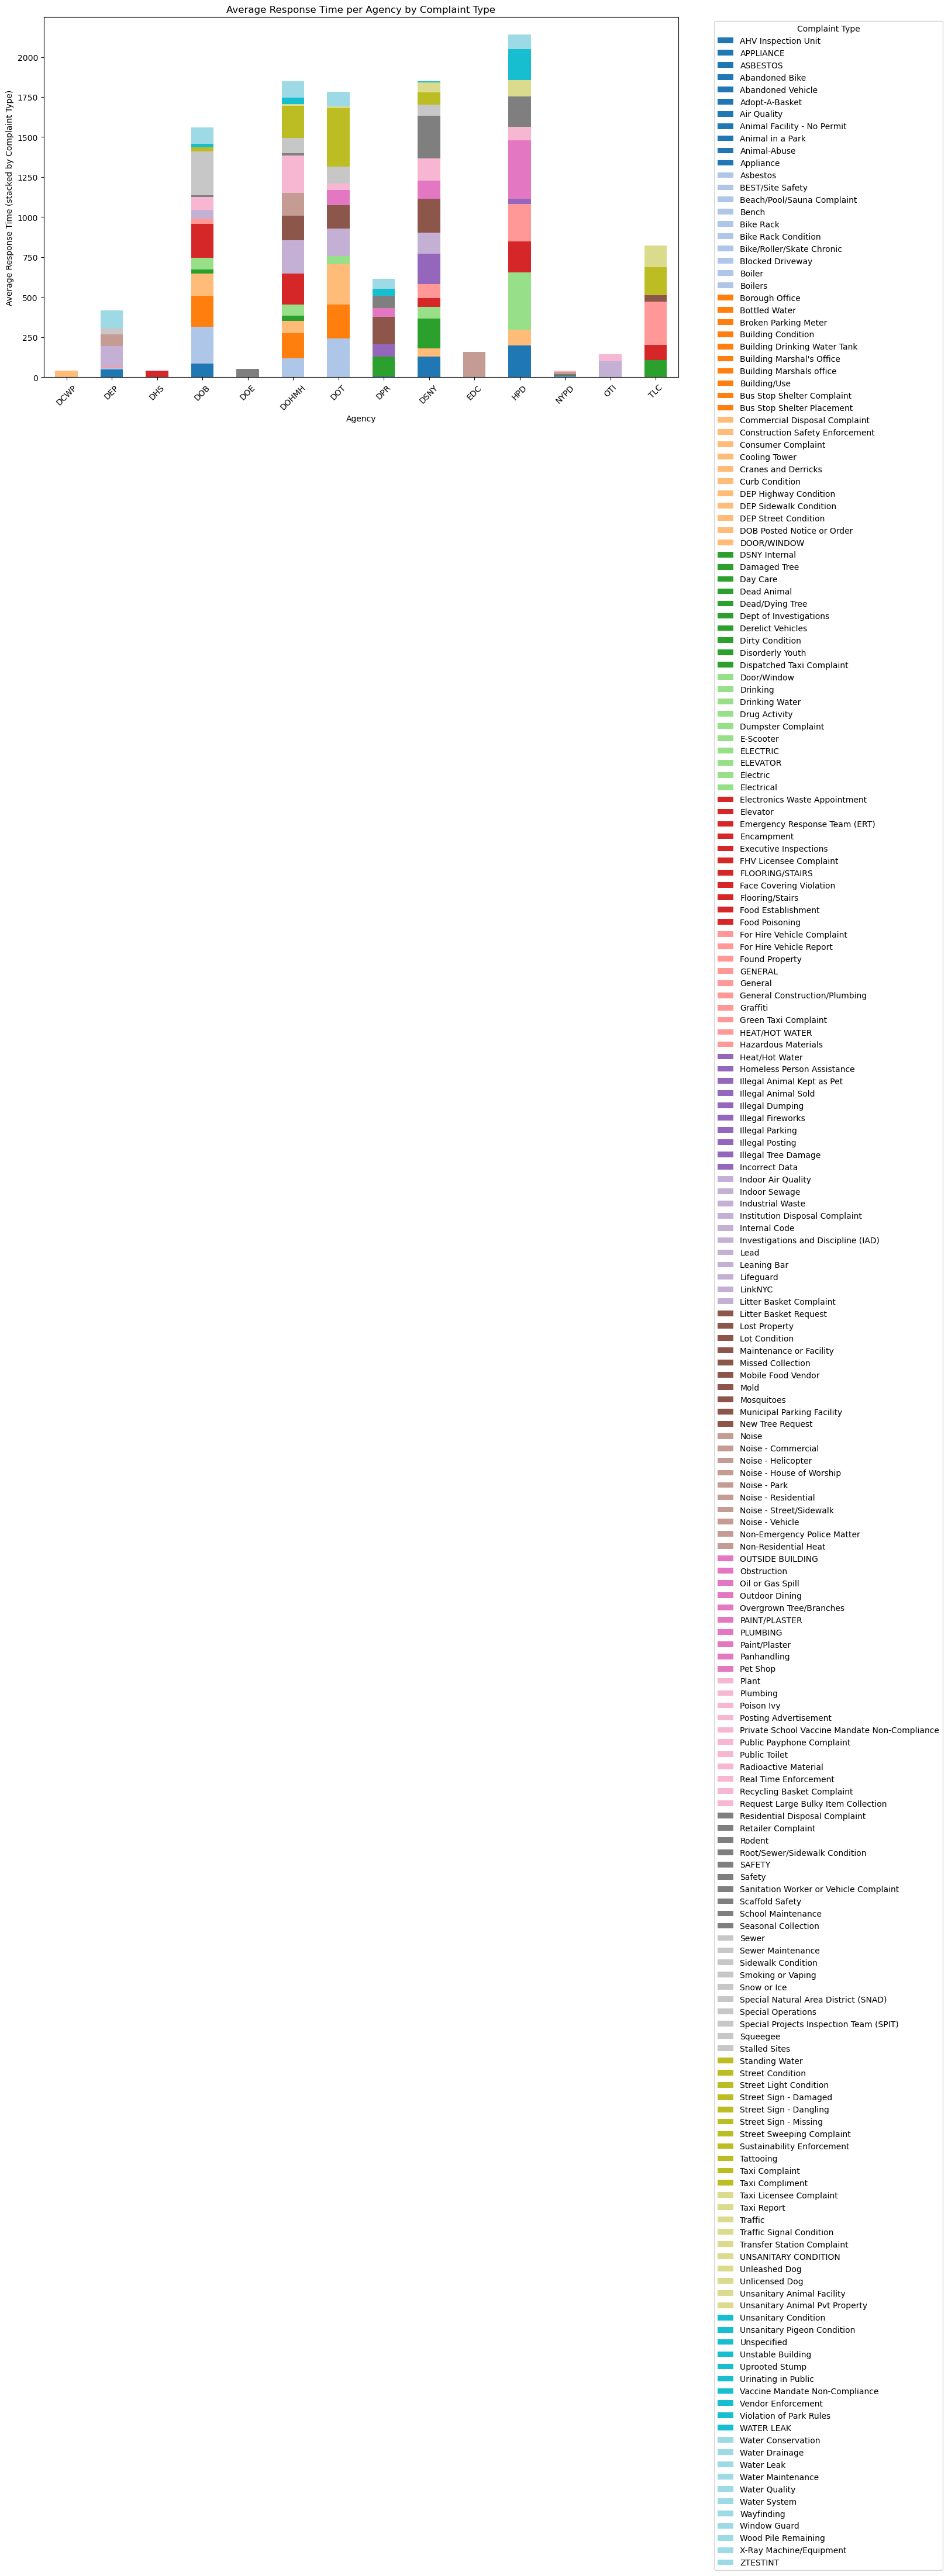

In [38]:
# Group by Agency and Complaint Type, calculate average Response Time
response_time_per_agency_type = df.groupby(['Agency', 'Complaint Type'])['response_time'].mean().unstack(fill_value=0)

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
response_time_per_agency_type.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.xlabel('Agency')
plt.ylabel('Average Response Time (stacked by Complaint Type)')
plt.title('Average Response Time per Agency by Complaint Type')
plt.xticks(rotation=45)
plt.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


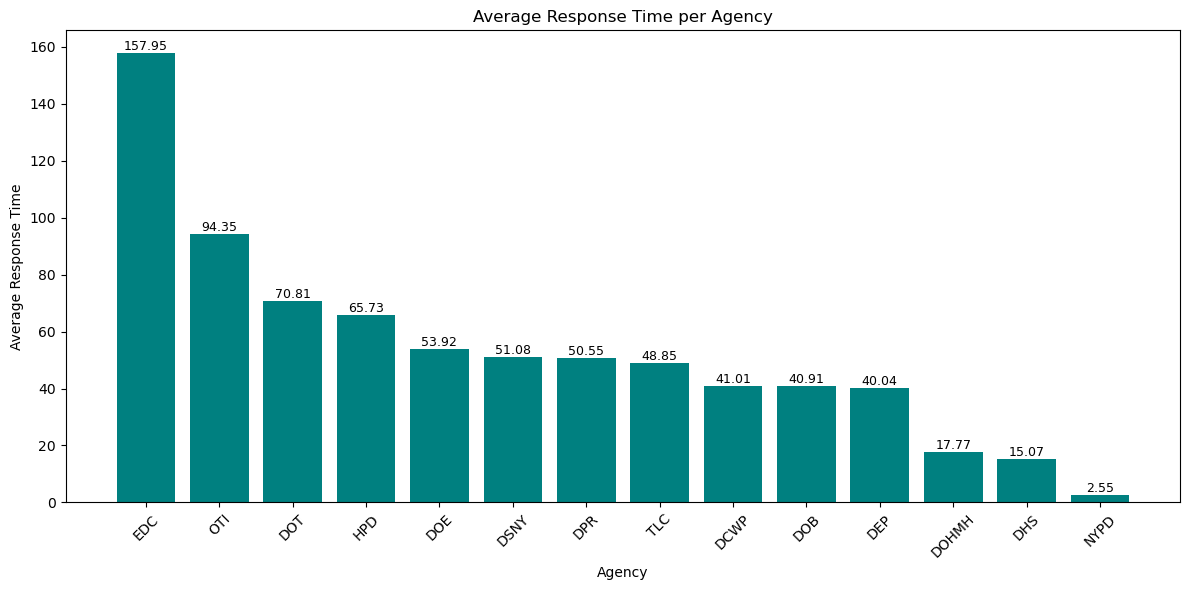

In [98]:

response_per_agency = df.groupby('Agency')['response_time'].mean().sort_values(ascending=False)

# plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(response_per_agency.index, response_per_agency.values, color='teal')
plt.xlabel('Agency')
plt.ylabel('Average Response Time')
plt.title('Average Response Time per Agency')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()

# data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

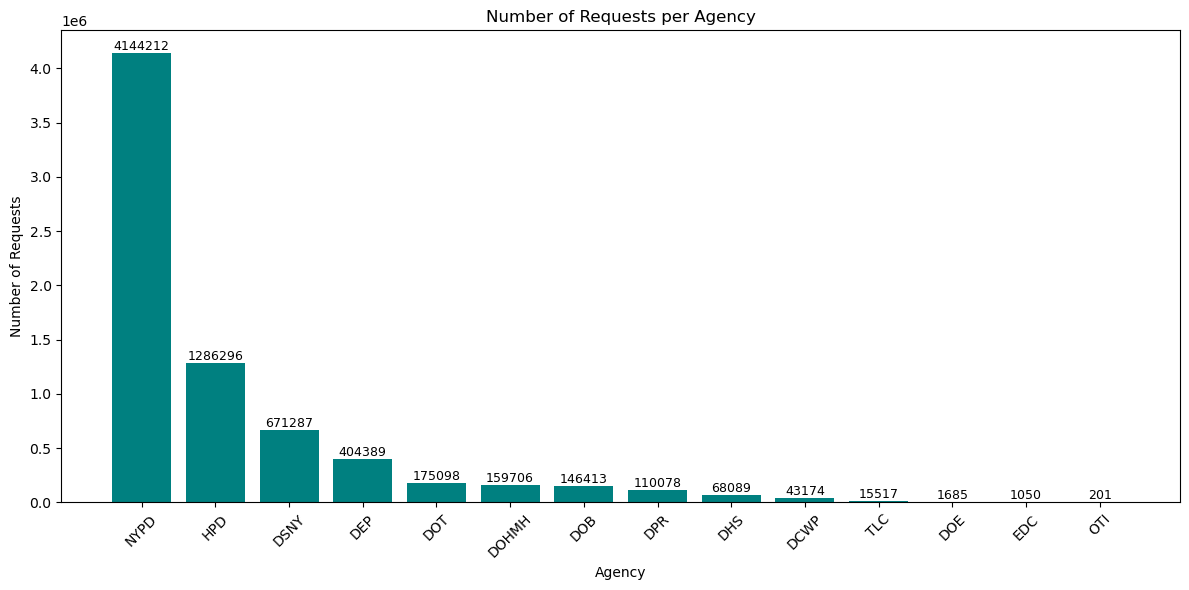

In [40]:
# Group by Agency and count number of requests
requests_per_agency = df.groupby('Agency').size().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(requests_per_agency.index, requests_per_agency.values, color='teal')
plt.xlabel('Agency')
plt.ylabel('Number of Requests')
plt.title('Number of Requests per Agency')
plt.xticks(rotation=45)  # Rotate labels for readability

# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# Train data wth Grid search

In [ ]:
X_train, X_test, y_train, y_test, y_pred, bestModel = modelDataWithGridSearch(df, test_size=0.2, random_state=42, stratify=df['Open Data Channel Type'])

# Train with xgboost

[0]	train-rmse:1.24641	validation_0-rmse:1.24669
[1]	train-rmse:1.00597	validation_0-rmse:1.00638
[2]	train-rmse:0.85186	validation_0-rmse:0.85232
[3]	train-rmse:0.75152	validation_0-rmse:0.75222
[4]	train-rmse:0.69237	validation_0-rmse:0.69317
[5]	train-rmse:0.63770	validation_0-rmse:0.63845
[6]	train-rmse:0.59732	validation_0-rmse:0.59835
[7]	train-rmse:0.57844	validation_0-rmse:0.57956
[8]	train-rmse:0.55234	validation_0-rmse:0.55353
[9]	train-rmse:0.53808	validation_0-rmse:0.53938
[10]	train-rmse:0.51735	validation_0-rmse:0.51873
[11]	train-rmse:0.50511	validation_0-rmse:0.50650
[12]	train-rmse:0.49243	validation_0-rmse:0.49385
[13]	train-rmse:0.48403	validation_0-rmse:0.48547
[14]	train-rmse:0.47504	validation_0-rmse:0.47652
[15]	train-rmse:0.47165	validation_0-rmse:0.47324
[16]	train-rmse:0.46780	validation_0-rmse:0.46944
[17]	train-rmse:0.46509	validation_0-rmse:0.46683
[18]	train-rmse:0.45899	validation_0-rmse:0.46081
[19]	train-rmse:0.44444	validation_0-rmse:0.44632
[20]	train

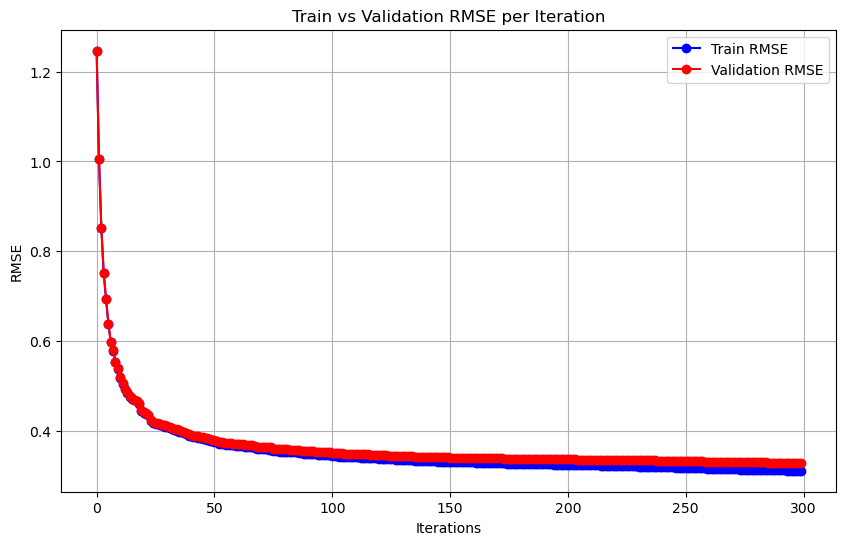

Validation Metrics:
MSE: 0.11
RMSE: 0.33
MAE: 0.17
R-squared: 0.96


In [25]:
X_train, X_test, y_train, y_test, y_pred, bestModel = modelData(df, test_size=0.2, random_state=42, stratify=df['Open Data Channel Type'])

# Interpreting the results

- RMSE plateaued: both training and validation RMSE have converged and stabilized, suggesting no overfitting or underfitting  
- MSE = 0.11	Average squared error is low (for log-scale).  
- RMSE = 0.33	Small average deviation in log units (e.g. log-hours).  
    np.exp(0.33) = 1.39 => The predicted response times are typically within a factor of ~1.39 of the true value  
- MAE	= 0.17	Median absolute error is smaller than RMSE (good sign, few big outliers).  
- R² = 0.96	Model explains 96% of the variance in log response time.  
=> No signs of overfitting, model generalizes well to unseen data. 

# Prediction

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.metrics import mean_squared_error, r2_score

def predict_random_rows(df, model_path='best_model_xgboost_raw_plot.pkl', encoder_path='label_encoders_xgboost_raw_plot.pkl', num_samples=5):
    """
    Randomly selects rows from a DataFrame, predicts response times using a trained XGBoost model,
    and optionally compares predictions with actual response times.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        model_path (str): Path to the saved XGBoost model.
        encoder_path (str): Path to the saved label encoders.
        num_samples (int): The number of random rows to sample and predict.

    Returns:
        pd.DataFrame: A DataFrame containing the sampled rows, their predicted response times,
                      and (if available) their actual response times.
    """

    # 1. Load the Model and Label Encoders
    bst = joblib.load(model_path)
    label_encoders = joblib.load(encoder_path)


    numerical_cols = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos', 'time_of_day Created Date',
                      'dayOfWeek Created Date', 'month Created Date', 'weekday Created Date',
                      'hour Created Date', 'Holiday Created Date', 'time_of_day Closed Date', 'dayOfWeek Closed Date',
                      'month Closed Date', 'weekday Closed Date', 'hour Closed Date']

    categorical_cols = ['Agency', 'Complaint Type', 'Street Name', 'City', 'Borough', 'Open Data Channel Type']
    features = numerical_cols + categorical_cols


    # 2. Randomly Select Rows
    sampled_df = df.sample(n=num_samples, random_state=42)  # You can adjust random_state


    # 3. Prepare Data and Make Predictions
    predictions = []
    for index, row in sampled_df.iterrows():
        # Extract Features
        X_sample = row[features].copy()

        # Encode Categorical Features
        for col in categorical_cols:
            X_sample[col] = label_encoders[col].transform([X_sample[col]])[0] # Transform and get the single value

        # Convert to DataFrame
        X_sample_df = pd.DataFrame([X_sample])

        # Create DMatrix
        d_sample = xgb.DMatrix(X_sample_df)

        # Make Prediction and Revert Log
        log_predicted_response_time = bst.predict(d_sample)[0]
        predicted_response_time = np.exp(log_predicted_response_time) # Revert the log transform

        predictions.append(predicted_response_time)


    # Add Predictions to the Sampled DataFrame
    sampled_df['predicted_response_time'] = predictions
    
    try:
        # In original scale
        sampled_df['actual_response_time'] = np.exp(sampled_df['logResponseTime'])
        mse = mean_squared_error(sampled_df['actual_response_time'], sampled_df['predicted_response_time'])
        rmse = np.sqrt(mse)
        r2 = r2_score(sampled_df['actual_response_time'], sampled_df['predicted_response_time'])
        print("Metrics on Sampled Data (Original scale):  MSE:", mse, " RMSE:", rmse, " R2:", r2)
    except KeyError:
        print("logResponseTime not found in sampled_df - cannot print metrics")


    try:
        # In log scale
        mse = mean_squared_error(sampled_df['logResponseTime'], np.log(sampled_df['predicted_response_time']))
        rmse = np.sqrt(mse)
        r2 = r2_score(sampled_df['logResponseTime'], np.log(sampled_df['predicted_response_time']))
        print("Metrics on Sampled Data (Original scale):  MSE:", mse, " RMSE:", rmse, " R2:", r2)
    except KeyError:
        print("logResponseTime not found in sampled_df - cannot print metrics")

    return sampled_df

In [59]:
randompredictions=predict_random_rows(df,num_samples=10)

Metrics on Sampled Data:  MSE: 125.17500521374362  RMSE: 11.188163621155333  R2: 0.9649373885732553


In [61]:
randompredictions[['predicted_response_time','actual_response_time']] # in original scale

,predicted_response_time,actual_response_time
32836175,1.290825,1.634167
37038889,112.807808,124.960000
38179322,131.853745,143.883333
33379208,2.756462,2.297222
36826647,163.685455,133.271111
2274399,136.366699,135.066667
37277494,16.783575,12.120833
38206514,53.236221,53.977778
38829283,30.128370,26.966667
37732660,1.741394,1.584444


# Get feature importances

In [53]:
bst = joblib.load('best_model_xgboost_raw_plot.pkl')

{'lat_sin': 17.545997619628906, 'lat_cos': 18.47245979309082, 'lon_sin': 16.665847778320312, 'lon_cos': 20.78046989440918, 'time_of_day Created Date': 54.888458251953125, 'dayOfWeek Created Date': 97.69759368896484, 'month Created Date': 13.933402061462402, 'hour Created Date': 111.25865173339844, 'Holiday Created Date': 34.20876693725586, 'dayOfWeek Closed Date': 101.76342010498047, 'month Closed Date': 19.95940399169922, 'hour Closed Date': 111.32709503173828, 'Agency': 2329.849853515625, 'Complaint Type': 137.7957000732422, 'Street Name': 2.8136847019195557, 'City': 18.776931762695312, 'Borough': 81.863037109375, 'Open Data Channel Type': 89.50033569335938}


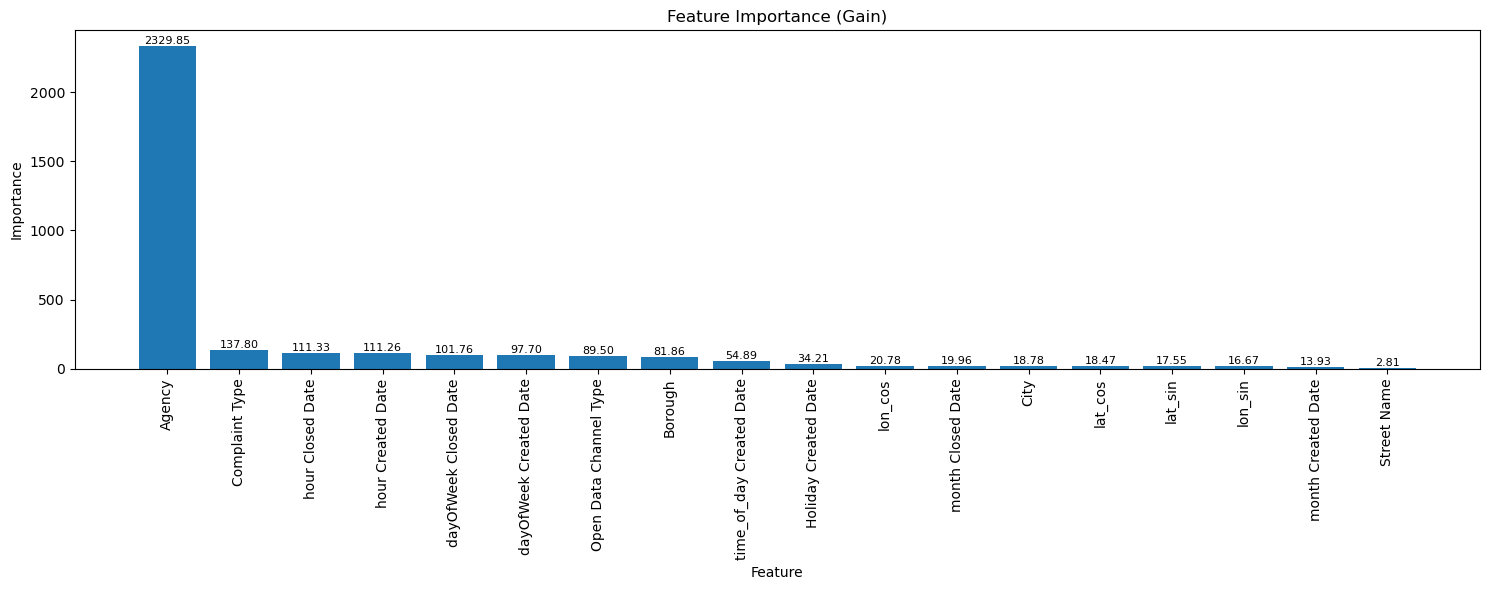

In [76]:
def plot_feature_importance_old(bst, features, importance_type='gain'):  # Added importance_type
    """Plots feature importances from XGBoost model using bst.get_score()."""

    importance = bst.get_score(importance_type=importance_type) # specified importance type
    print(importance)
    feature_names = features
    
    feature_map={f'f{i}':feature_name for i, feature_name in enumerate(feature_names)}
    
    feature_importance = pd.DataFrame({'feature': [feature_map.get(f,f) for f in importance.keys()], 'importance':list(importance.values())})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    
    plt.figure(figsize=(15, 6))
    bars = plt.bar(feature_importance['feature'], feature_importance['importance'])
    
    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, 
                 f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance ({importance_type.capitalize()})') # Modified Title
    plt.tight_layout()
    plt.show()

numerical_cols = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos', 'time_of_day Created Date',
                  'dayOfWeek Created Date', 'month Created Date', 'weekday Created Date',
                  'hour Created Date', 'Holiday Created Date', 'time_of_day Closed Date', 'dayOfWeek Closed Date',
                  'month Closed Date', 'weekday Closed Date', 'hour Closed Date']

categorical_cols = ['Agency', 'Complaint Type', 'Street Name', 'City', 'Borough', 'Open Data Channel Type']
features = numerical_cols + categorical_cols


plot_feature_importance_old(bst, features)

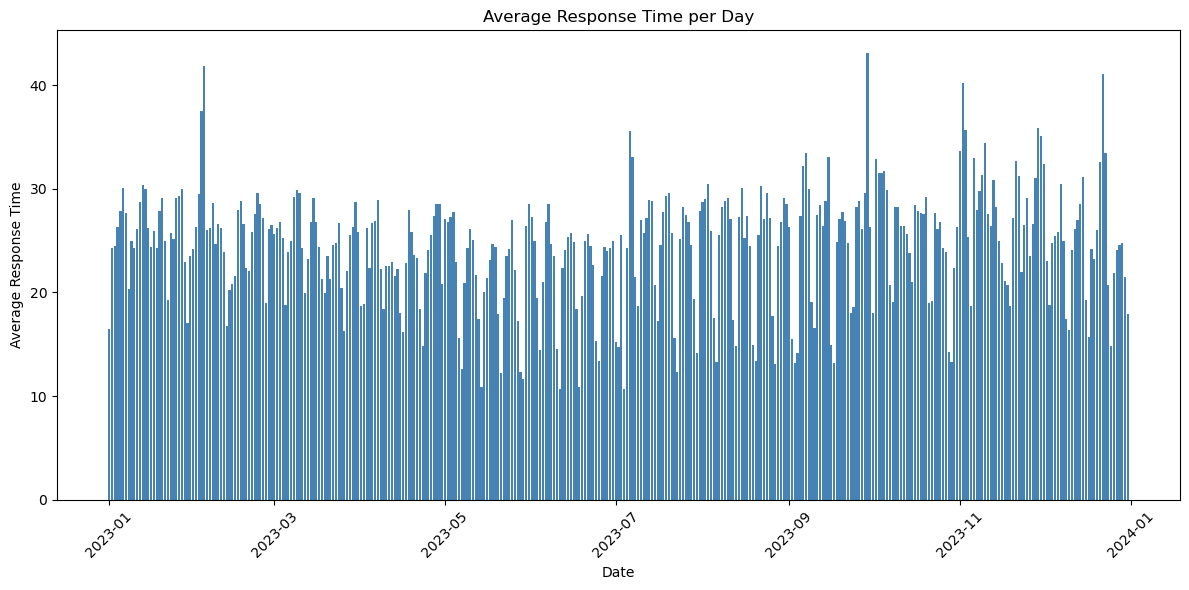

In [89]:
# Filtering data to one year
df_2023 = df[df['Created Date'].dt.year == 2023]

# Daily Average
response_per_day = df_2023.groupby(df_2023['Created Date'].dt.date)['response_time'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(response_per_day.index, response_per_day.values, color='steelblue')
plt.xlabel('Date')
plt.ylabel('Average Response Time')
plt.title('Average Response Time per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# def evaluateAndCompare(y_test_log, y_pred_log):
#     # 1. Metrics in log-space
#     mse_log = mean_squared_error(y_test_log, y_pred_log)
#     rmse_log = np.sqrt(mse_log)
#     mae_log = mean_absolute_error(y_test_log, y_pred_log)
#     r2_log = r2_score(y_test_log, y_pred_log)

#     print("📉 Log-space Metrics:")
#     print(f"  MSE: {mse_log:.4f}")
#     print(f"  RMSE: {rmse_log:.4f}")
#     print(f"  MAE: {mae_log:.4f}")
#     print(f"  R²: {r2_log:.4f}")

#     # 2. Back-transform to real-time
#     y_test_real = np.exp(y_test_log)
#     y_pred_real = np.exp(y_pred_log)

#     # 3. Metrics in real-time units
#     mse_real = mean_squared_error(y_test_real, y_pred_real)
#     rmse_real = np.sqrt(mse_real)
#     mae_real = mean_absolute_error(y_test_real, y_pred_real)
#     r2_real = r2_score(y_test_real, y_pred_real)

#     print("\n⏱️ Real-time Metrics:")
#     print(f"  MSE: {mse_real:.2f}")
#     print(f"  RMSE: {rmse_real:.2f} hours")
#     print(f"  MAE: {mae_real:.2f} hours")
#     print(f"  R²: {r2_real:.4f}")

#     # 4. Return a DataFrame with formatted durations
#     def format_duration(hours):
#         days = int(hours // 24)
#         hrs = int(hours % 24)
#         mins = int((hours * 60) % 60)
#         return f"{days}d {hrs}h {mins}m"

#     result_df = pd.DataFrame({
#         'True (hrs)': y_test_real,
#         'Predicted (hrs)': y_pred_real,
#         'Formatted True': y_test_real.apply(format_duration),
#         'Formatted Pred': y_pred_real.apply(format_duration),
#     })

#     return result_df
